Importing necessary libraries

In [107]:
import numpy as np
import pandas as pd

# For statistical tests
from scipy import stats

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For entropy computation
from pyitlib import discrete_random_variable as drv

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

Reading data

In [2]:
raw_data = pd.read_csv('Fraud_Data.csv')
ip_country = pd.read_csv('IpAddress_to_Country.csv')

Getting information from IP table

In [3]:
ip_country.upper_bound_ip_address.astype('float')
ip_country.lower_bound_ip_address.astype('float')

def ip_add_to_country(ip):
  try:
    return ip_country.country[(ip_country.lower_bound_ip_address < ip)                            
                                & 
                                (ip_country.upper_bound_ip_address > ip)].iloc[0]
  except:
    return "NA"
raw_data["country"] = raw_data.ip_address.apply(ip_add_to_country)

In [122]:
data = raw_data.copy()

Deriving more columns

In [123]:
# get diff in days, time, seconds, quick_purchase from purchase_time and signup_time
data['diff_dt'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time']))
data['days'] = data['diff_dt'].dt.days
data['time'] = data['diff_dt'].astype(str).apply(lambda x : x[-8:])
data["time"] = pd.to_datetime(data['time'],format= '%H:%M:%S' ).dt.time
data['seconds'] = data['diff_dt'].dt.total_seconds()
data['quick_purchase'] = data['seconds'].apply(lambda x: '1' if x < 30 else '0')

# get month, week, hour of the day from purchase_time
data['month_purchase'] = pd.to_datetime(data['purchase_time']).dt.strftime('%B')
data['weekday_purchase'] = pd.to_datetime(data['purchase_time']).dt.strftime('%A')
data['hour_of_the_day'] = pd.to_datetime(data['purchase_time']).dt.strftime('%H').astype(int)

# categorise hour of the day
data["period_of_the_day"] = data['hour_of_the_day'].apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

# get country risk from mean of class
risk_country = pd.DataFrame(data.groupby(by="country").mean()["class"].sort_values(ascending = False))
risk_country["risk_country"] = risk_country["class"].apply(lambda x:"High Risk" if x > 0.25 else "Medium Risk" if x > 0.10 else "Low Risk")
data = data.merge(risk_country.drop("class",axis=1),left_on='country', right_on = 'country')

# get count of duplicated devices
device_duplicates = data.groupby('device_id')['device_id'].count().rename('freq_device').reset_index()
data = data.merge(device_duplicates, on='device_id')
data['freq_device_cat'] = data['freq_device'].apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# get count of countries by device_id
country_count = data.groupby(["device_id", "country"])['country'].count().rename('country_count').reset_index()
data = data.merge(country_count, on=["device_id", 'country'], how='left')

# get count of same purchase by device_id
duplicate = data.groupby(['device_id', 'purchase_value'])['purchase_value'].count().rename('freq_same_purchase').reset_index()
data = data.merge(duplicate, on=['device_id', 'purchase_value'], how='left')
data["freq_same_purchase_cat"] = data['freq_same_purchase'].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )

# categorise age
data["age_category"] = data['age'].apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

In [128]:
f_data = data[data["class"] == 1]
non_f_data = data[data["class"] == 0]

numerical_variables = ['user_id', 'purchase_value', 'age', 'ip_address', 'days', 'seconds', 'freq_device', 'country_count', 'freq_same_purchase']
cat_variables = ['class', 'source', 'browser', 'sex', 'country', 'quick_purchase', 'month_purchase', 'weekday_purchase', 'period_of_the_day', 'risk_country', 'freq_device_cat', 'freq_same_purchase_cat', 'age_category']

In [7]:
data.dtypes

user_id                             int64
signup_time                        object
purchase_time                      object
purchase_value                      int64
device_id                          object
source                             object
browser                            object
sex                                object
age                                 int64
ip_address                        float64
class                               int64
country                            object
diff_dt                   timedelta64[ns]
days                                int64
time                               object
seconds                           float64
quick_purchase                      int64
month_purchase                     object
weekday_purchase                   object
hour_of_the_day                     int64
period_of_the_day                  object
risk_country                       object
freq_device                         int64
freq_device_cat                   

## Exploratory Data Analysis

Robust vs Non Robust Statistics

Sd and MAD are not too far from each other. 

In [8]:
print (f'mean: {np.mean(data["purchase_value"])}')
print (f'median: {np.median(data["purchase_value"])}')
print (f'std: {np.std(data["purchase_value"])}')
print (f'MAE: {stats.median_abs_deviation(data["purchase_value"])}')

mean: 36.93537243898565
median: 35.0
std: 18.322701522130576
MAE: 13.0


Quantile Statistics

In [9]:
quantile = f_data[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
user_id,3.900000e+01,9.831400e+04,2.005260e+05,3.030180e+05,4.000000e+05,3.999610e+05,2.047040e+05
purchase_value,9.000000e+00,2.200000e+01,3.500000e+01,4.900000e+01,1.110000e+02,1.020000e+02,2.700000e+01
age,1.800000e+01,2.700000e+01,3.300000e+01,3.900000e+01,6.800000e+01,5.000000e+01,1.200000e+01
ip_address,2.278096e+06,1.107616e+09,2.141692e+09,3.184225e+09,4.294131e+09,4.291853e+09,2.076609e+09
days,0.000000e+00,0.000000e+00,0.000000e+00,5.500000e+01,1.190000e+02,1.190000e+02,5.500000e+01
seconds,1.000000e+00,1.000000e+00,1.000000e+00,4.790510e+06,1.036395e+07,1.036395e+07,4.790510e+06
freq_device,1.000000e+00,1.000000e+00,8.000000e+00,1.200000e+01,2.000000e+01,1.900000e+01,1.100000e+01
country_count,1.000000e+00,1.000000e+00,8.000000e+00,1.200000e+01,2.000000e+01,1.900000e+01,1.100000e+01
freq_same_purchase,1.000000e+00,1.000000e+00,8.000000e+00,1.200000e+01,2.000000e+01,1.900000e+01,1.100000e+01


In [10]:
quantile = non_f_data[numerical_variables].describe().loc[['min', '25%', '50%', '75%', 'max']].transpose()
quantile.columns = ['min', 'Q1', 'Q2', 'Q3', 'max']
quantile['range'] = quantile['max'] - quantile['min']
quantile['IQR'] = quantile['Q3'] - quantile['Q1']
quantile

,min,Q1,Q2,Q3,max,range,IQR
user_id,2.000000,1.007890e+05,1.999090e+05,2.997240e+05,3.999970e+05,3.999950e+05,1.989350e+05
purchase_value,9.000000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02,1.450000e+02,2.700000e+01
age,18.000000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01,5.800000e+01,1.200000e+01
ip_address,52093.496895,1.084381e+09,2.155916e+09,3.249408e+09,4.294850e+09,4.294798e+09,2.165028e+09
days,0.000000,2.900000e+01,6.000000e+01,9.000000e+01,1.190000e+02,1.190000e+02,6.100000e+01
seconds,137.000000,2.588829e+06,5.194911e+06,7.781319e+06,1.036797e+07,1.036784e+07,5.192490e+06
freq_device,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,1.900000e+01,0.000000e+00
country_count,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,1.900000e+01,0.000000e+00
freq_same_purchase,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+01,1.900000e+01,0.000000e+00


Kurtosis and Skewness on purchase_value

Kurtosis:-0.005	Skewness: -0.006


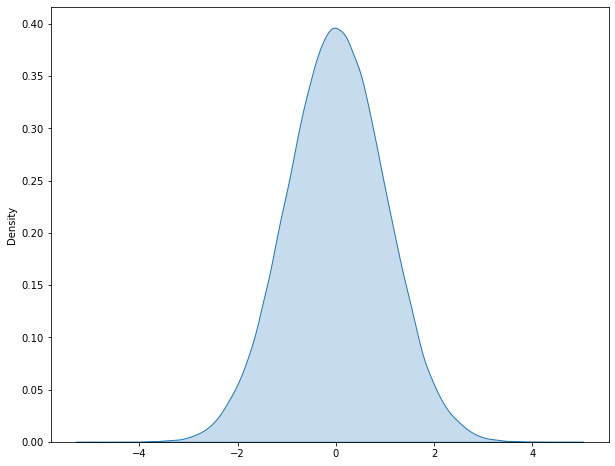

In [11]:
fig = plt.figure(figsize = (10, 8))
s = np.random.normal(0.0, 1.0, 100000)
data1 = f_data[['purchase_value']]
k1 = round(stats.kurtosis(s), 3)
s1 = round(stats.skew(s), 3)
print (f'Kurtosis:{k1}\tSkewness: {s1}')
sns.kdeplot(s, fill=True)
plt.show()

Kurtosis:0.009	Skewness: -0.006


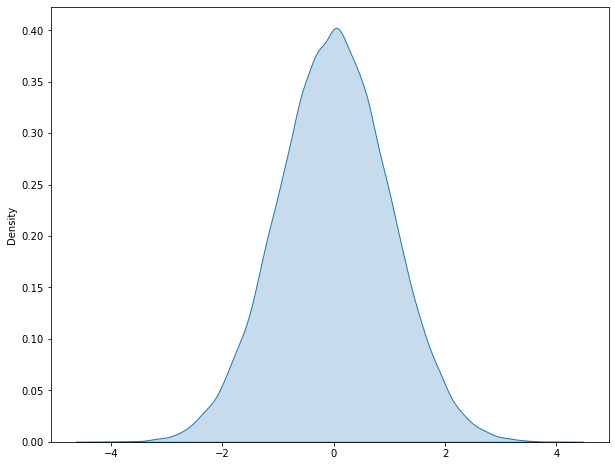

In [12]:
fig = plt.figure(figsize = (10, 8))
s = np.random.normal(0.0, 1.0, 100000)
data1 = non_f_data[['purchase_value']]
k1 = round(stats.kurtosis(s), 3)
s1 = round(stats.skew(s), 3)
print (f'Kurtosis:{k1}\tSkewness: {s1}')
sns.kdeplot(s, fill=True)
plt.show()

Descriptive Statistics

In [13]:
descriptive_stats = data[numerical_variables].describe().loc[['mean', 'std', '50%']].transpose()
descriptive_stats.columns = ['mean', 'std', 'median']
descriptive_stats['mode'] = data[numerical_variables].mode().transpose()[0]
descriptive_stats['mad'] = [stats.median_abs_deviation(data[x]) for x in numerical_variables]
descriptive_stats['kurtosis'] = [stats.kurtosis(data[x], fisher=False) for x in numerical_variables]
descriptive_stats['excess kurtosis'] = [stats.kurtosis(data[x], fisher=True) for x in numerical_variables]
descriptive_stats['skewness'] = [stats.skew(data[x]) for x in numerical_variables]

descriptive_stats

,mean,std,median,mode,mad,kurtosis,excess kurtosis,skewness
user_id,2.001710e+05,1.153693e+05,1.999580e+05,2.000000e+00,9.970200e+04,1.802732,-1.197268,0.000161
purchase_value,3.693537e+01,1.832276e+01,3.500000e+01,2.800000e+01,1.300000e+01,3.138247,0.138247,0.670478
age,3.314070e+01,8.617733e+00,3.300000e+01,3.200000e+01,6.000000e+00,2.826567,-0.173433,0.425476
ip_address,2.152145e+09,1.248497e+09,2.154770e+09,5.760609e+08,1.078561e+09,1.789339,-1.210661,-0.007053
days,5.660980e+01,3.614208e+01,5.700000e+01,0.000000e+00,3.200000e+01,1.773089,-1.226911,0.022023
seconds,4.932029e+06,3.126263e+06,4.926346e+06,1.000000e+00,2.727695e+06,1.776283,-1.223717,0.018887
freq_device,1.684367e+00,2.616954e+00,1.000000e+00,1.000000e+00,0.000000e+00,21.270151,18.270151,4.319704
country_count,1.617846e+00,2.599938e+00,1.000000e+00,1.000000e+00,0.000000e+00,21.668312,18.668312,4.383619
freq_same_purchase,1.603923e+00,2.596536e+00,1.000000e+00,1.000000e+00,0.000000e+00,21.768289,18.768289,4.398909


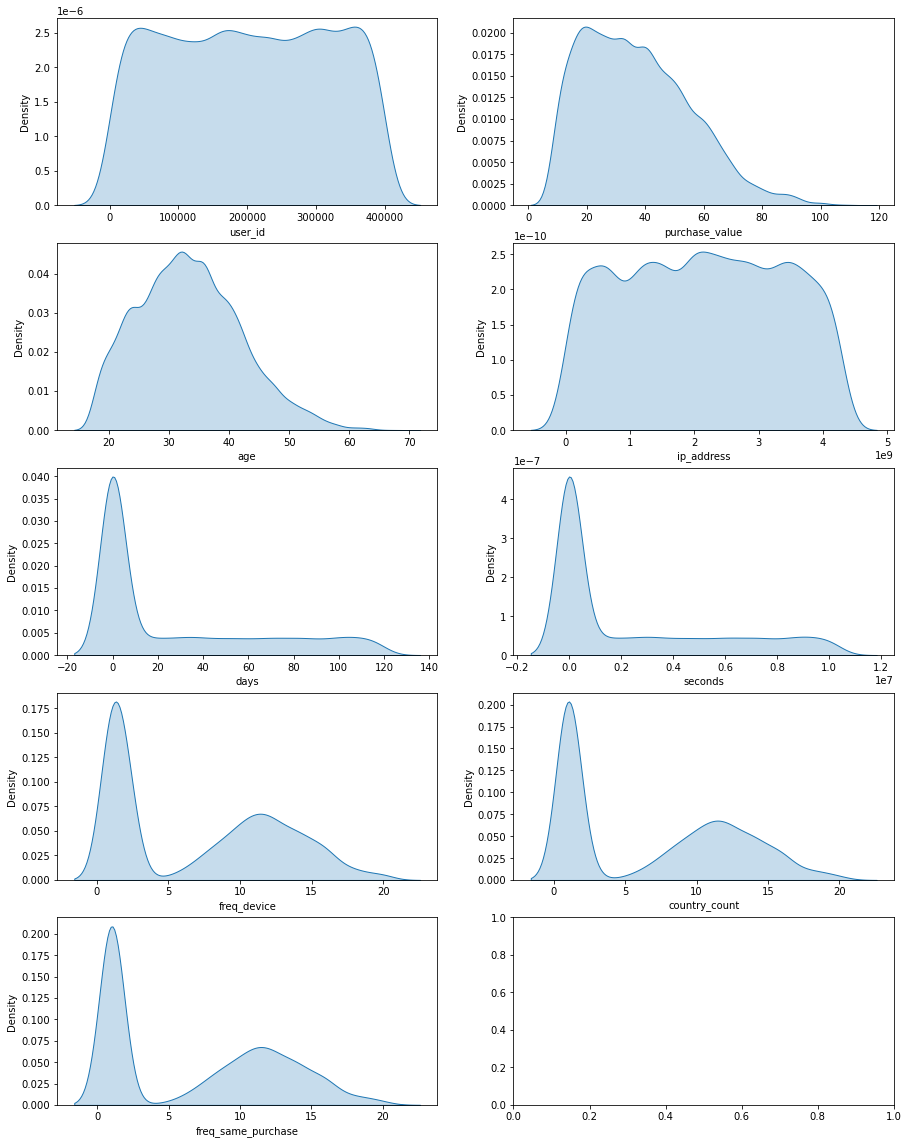

In [14]:
fig, ax =plt.subplots(5,2, figsize=(15, 20))

sns.kdeplot(f_data[numerical_variables[0]], fill=True, ax=ax[0, 0])
sns.kdeplot(f_data[numerical_variables[1]], fill=True, ax=ax[0, 1])
sns.kdeplot(f_data[numerical_variables[2]], fill=True, ax=ax[1, 0])
sns.kdeplot(f_data[numerical_variables[3]], fill=True, ax=ax[1, 1])
sns.kdeplot(f_data[numerical_variables[4]], fill=True, ax=ax[2, 0])
sns.kdeplot(f_data[numerical_variables[5]], fill=True, ax=ax[2, 1])
sns.kdeplot(f_data[numerical_variables[6]], fill=True, ax=ax[3, 0])
sns.kdeplot(f_data[numerical_variables[7]], fill=True, ax=ax[3, 1])
sns.kdeplot(f_data[numerical_variables[8]], fill=True, ax=ax[4, 0])

plt.show()

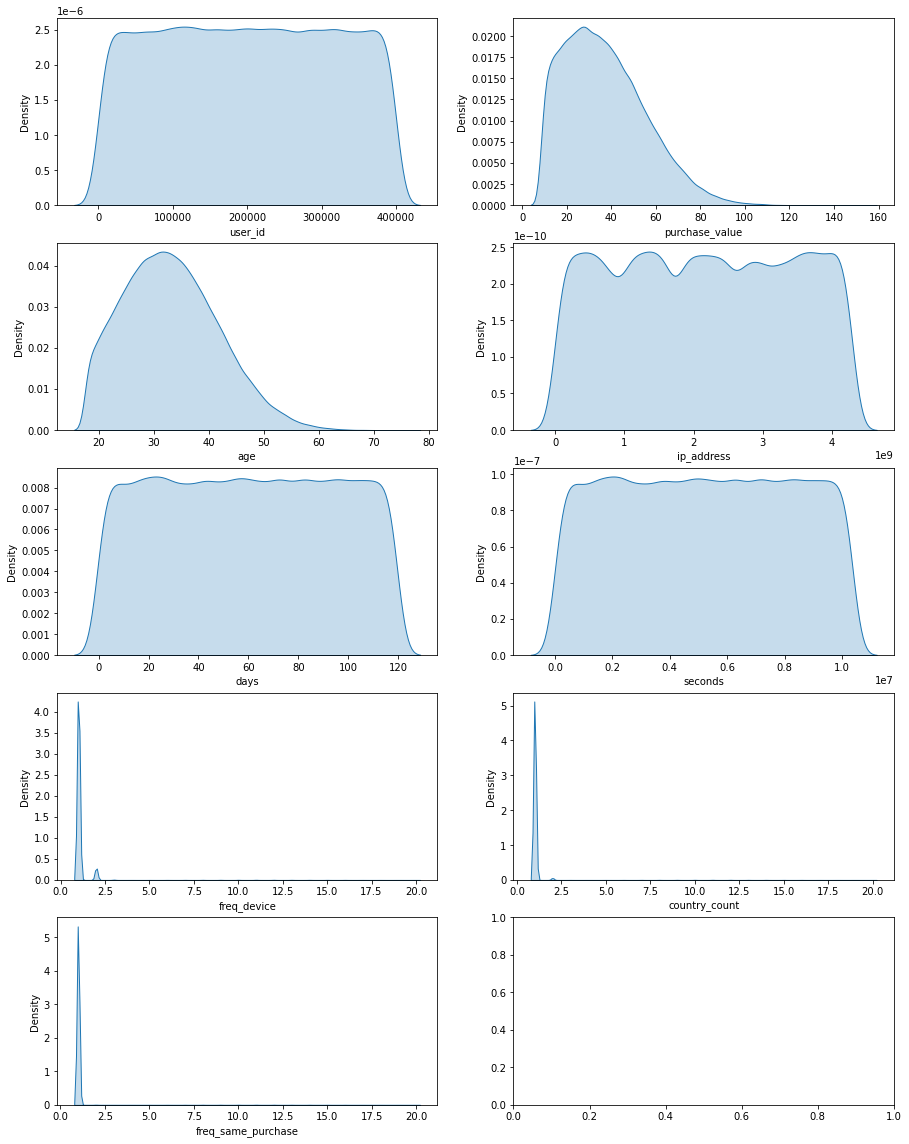

In [15]:
fig, ax =plt.subplots(5,2, figsize=(15, 20))

sns.kdeplot(non_f_data[numerical_variables[0]], fill=True, ax=ax[0, 0])
sns.kdeplot(non_f_data[numerical_variables[1]], fill=True, ax=ax[0, 1])
sns.kdeplot(non_f_data[numerical_variables[2]], fill=True, ax=ax[1, 0])
sns.kdeplot(non_f_data[numerical_variables[3]], fill=True, ax=ax[1, 1])
sns.kdeplot(non_f_data[numerical_variables[4]], fill=True, ax=ax[2, 0])
sns.kdeplot(non_f_data[numerical_variables[5]], fill=True, ax=ax[2, 1])
sns.kdeplot(non_f_data[numerical_variables[6]], fill=True, ax=ax[3, 0])
sns.kdeplot(non_f_data[numerical_variables[7]], fill=True, ax=ax[3, 1])
sns.kdeplot(non_f_data[numerical_variables[8]], fill=True, ax=ax[4, 0])

plt.show()

Histogram (for numerical descriptive analysis)

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_41717/3401759649.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[index] = plt.subplot(5, 2, index+1, label=str(index))


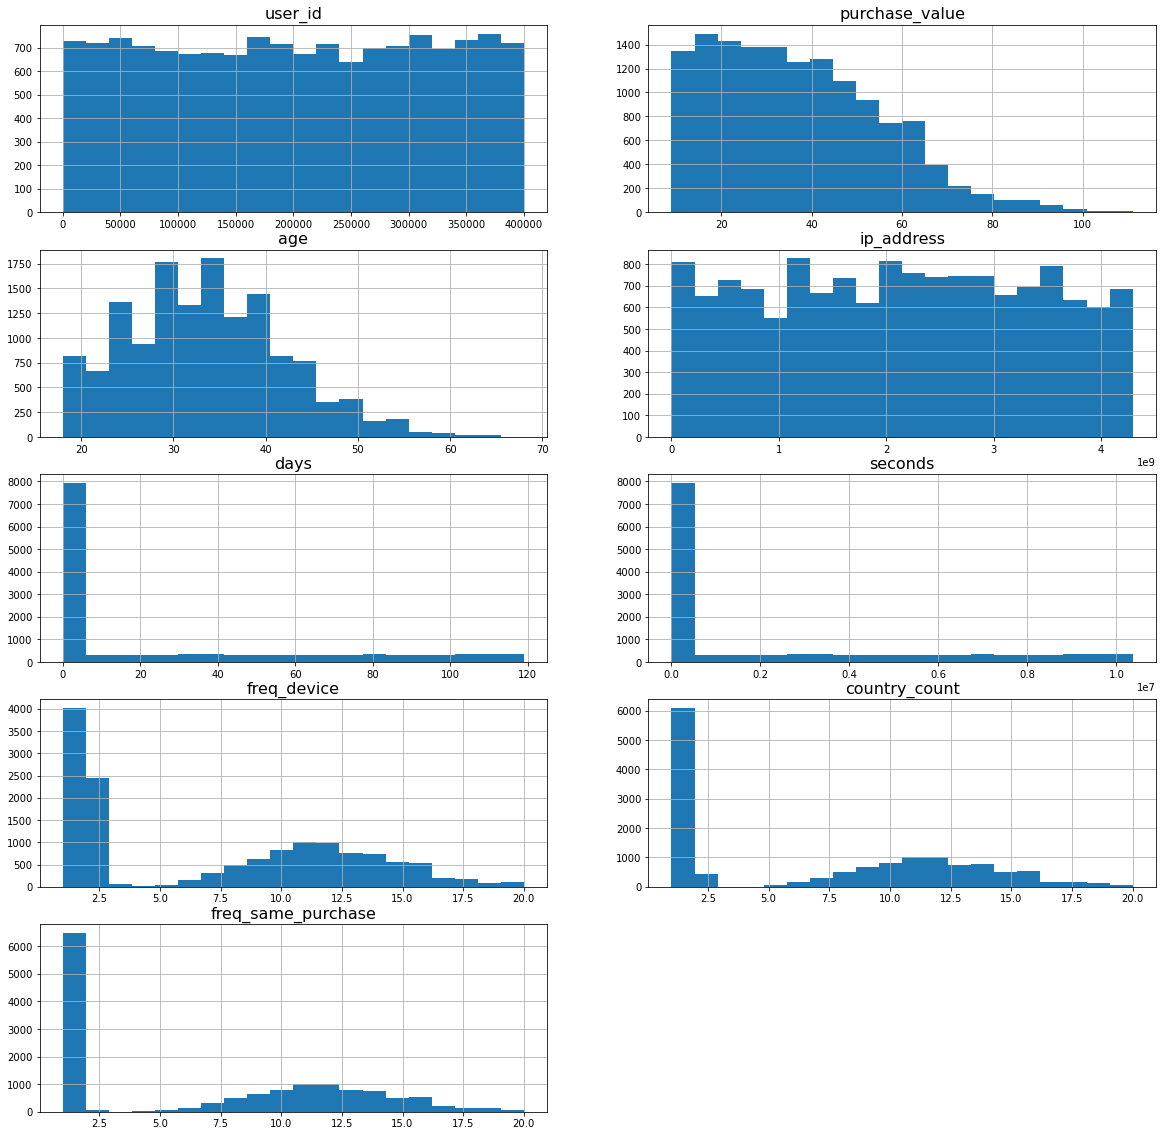

In [16]:
plt.figure(figsize=(20, 20))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(f_data[numerical_variables].columns):
    axes[index] = plt.subplot(5, 2, index+1, label=str(index))
    f_data[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

/var/folders/h6/cjxx3rb17jx8zzm4t27b_rf80000gn/T/ipykernel_41717/4175541606.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  axes[index] = plt.subplot(5, 2, index+1, label=str(index))


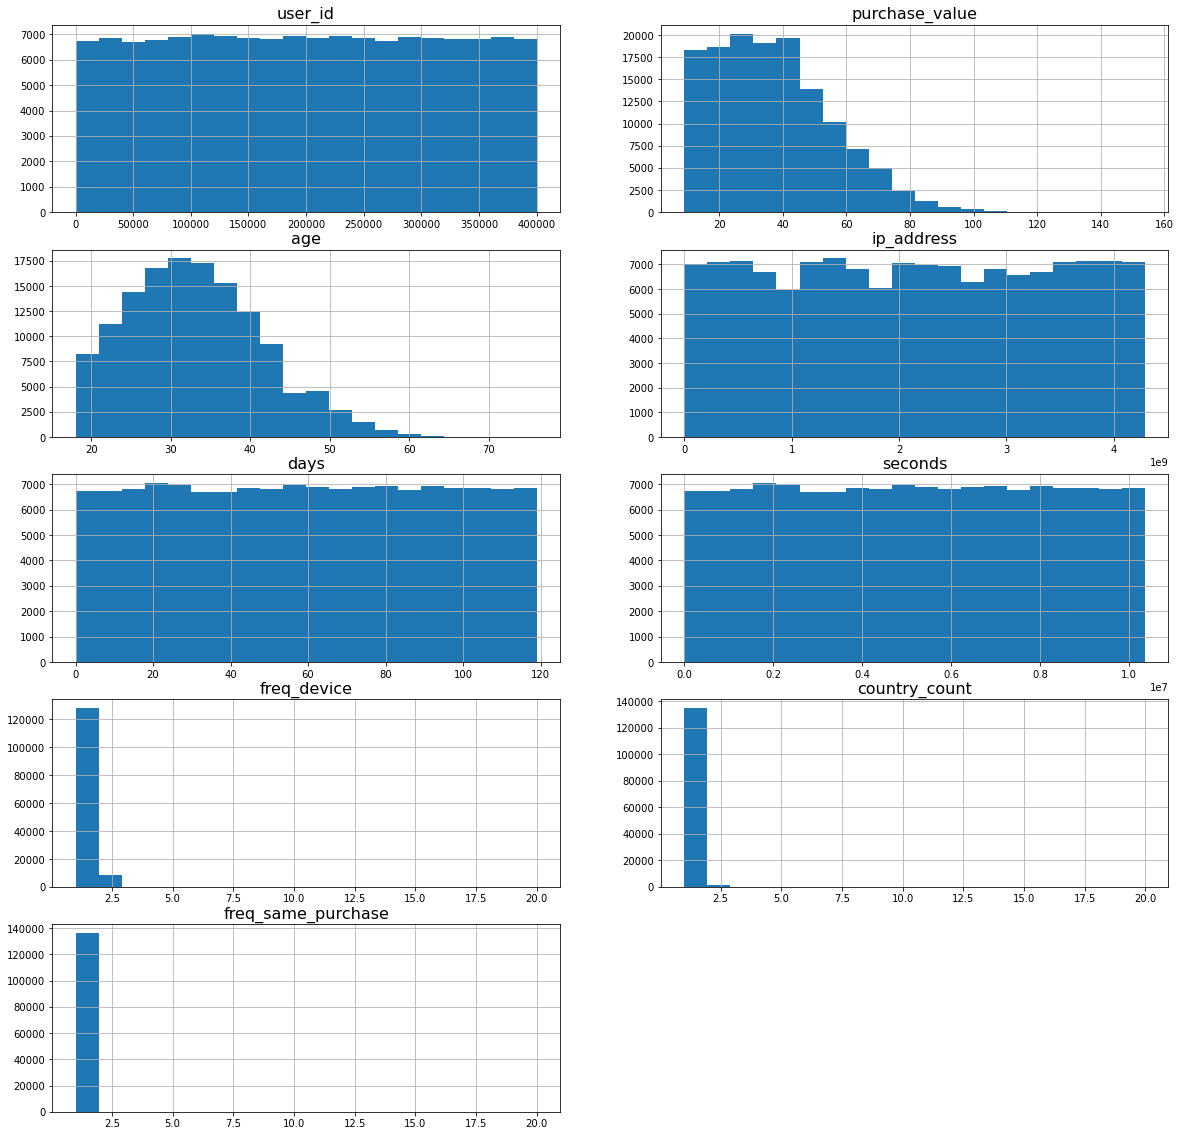

In [17]:
plt.figure(figsize=(20, 20))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(non_f_data[numerical_variables].columns):
    axes[index] = plt.subplot(5, 2, index+1, label=str(index))
    non_f_data[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

Cardinality and unique count (for categorical descriptive analysis)

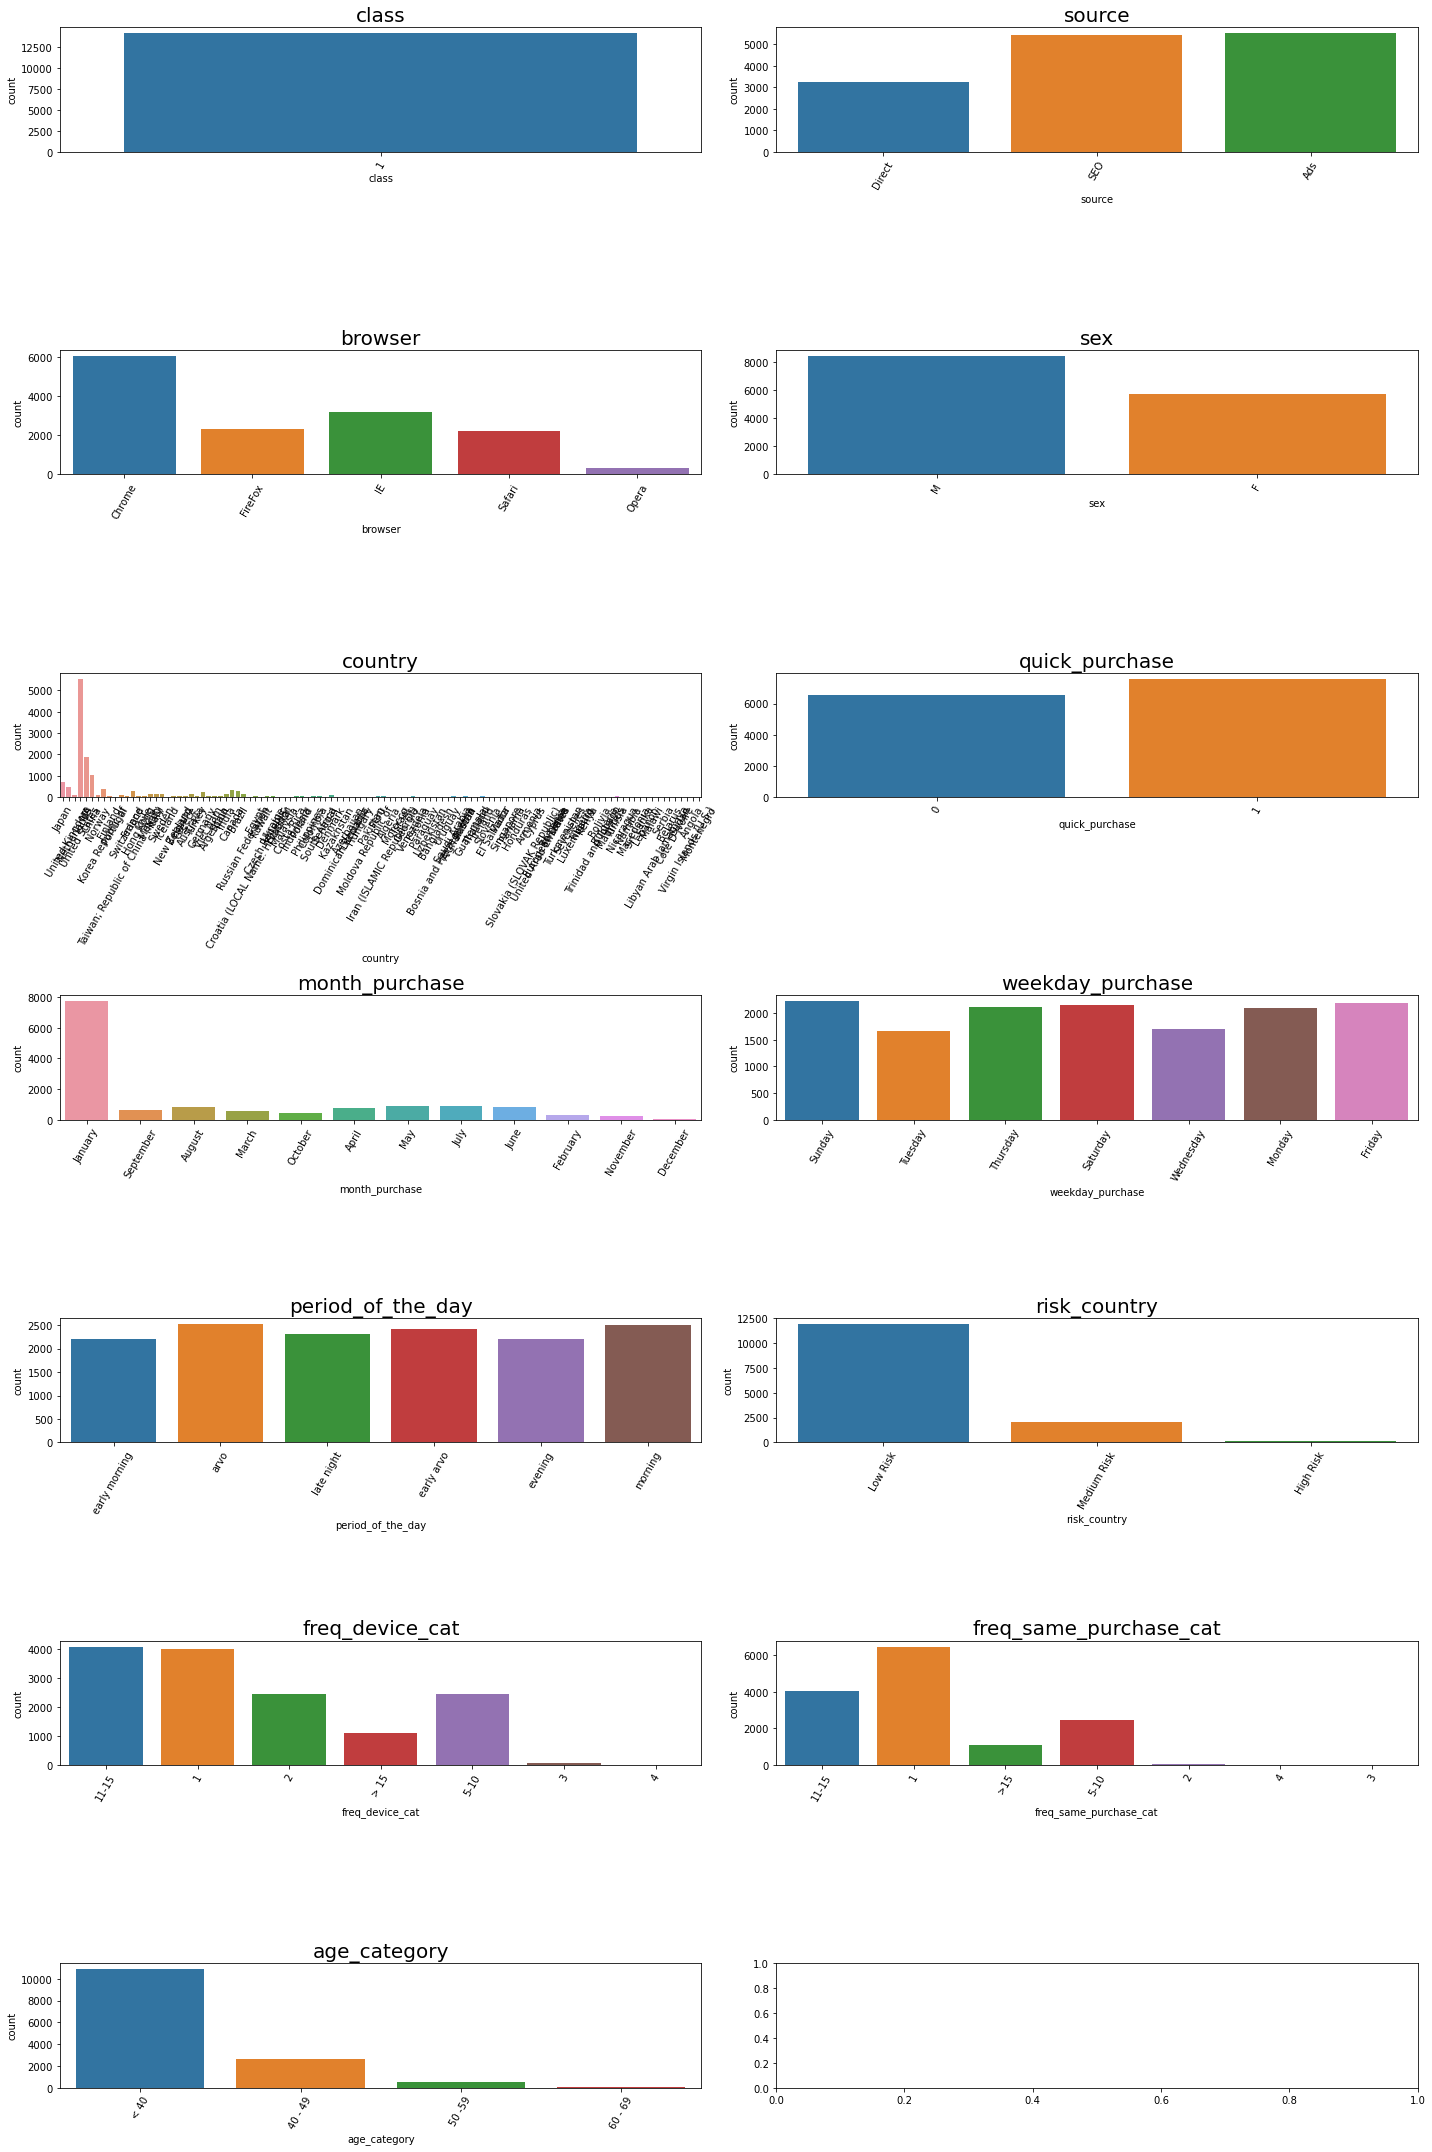

In [18]:
# Set up the matplotlib figure
f, axes = plt.subplots(7, 2, figsize=(20, 30), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

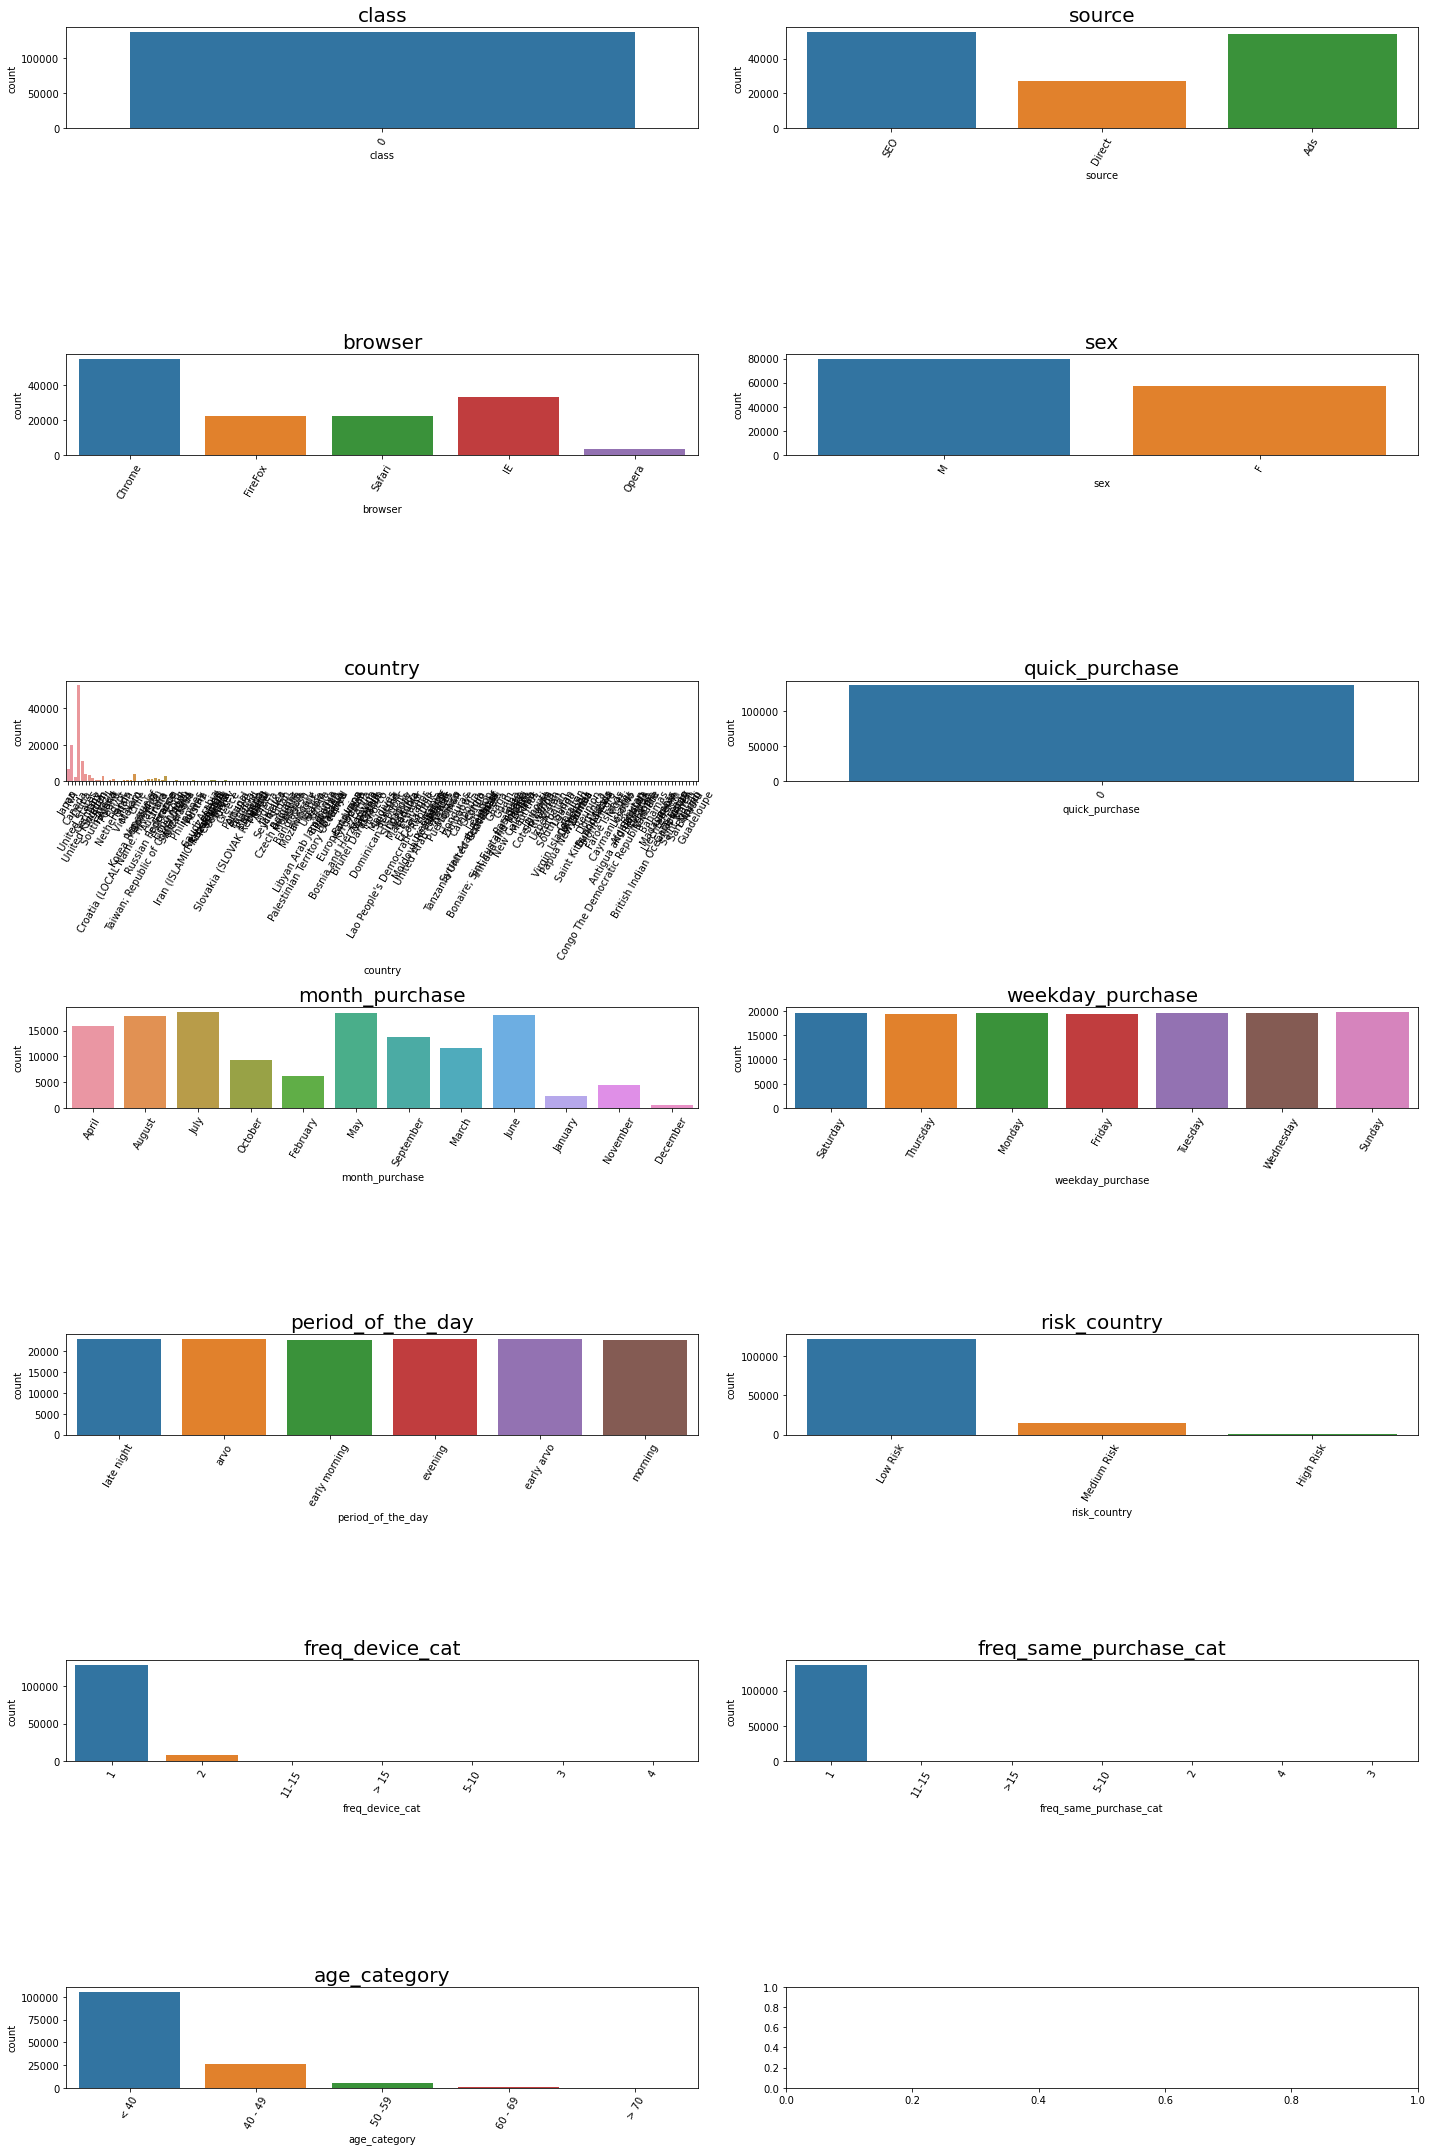

In [19]:
# Set up the matplotlib figure
f, axes = plt.subplots(7, 2, figsize=(20, 30), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=non_f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

Qualitative Analysis

Numerical vs Numerical

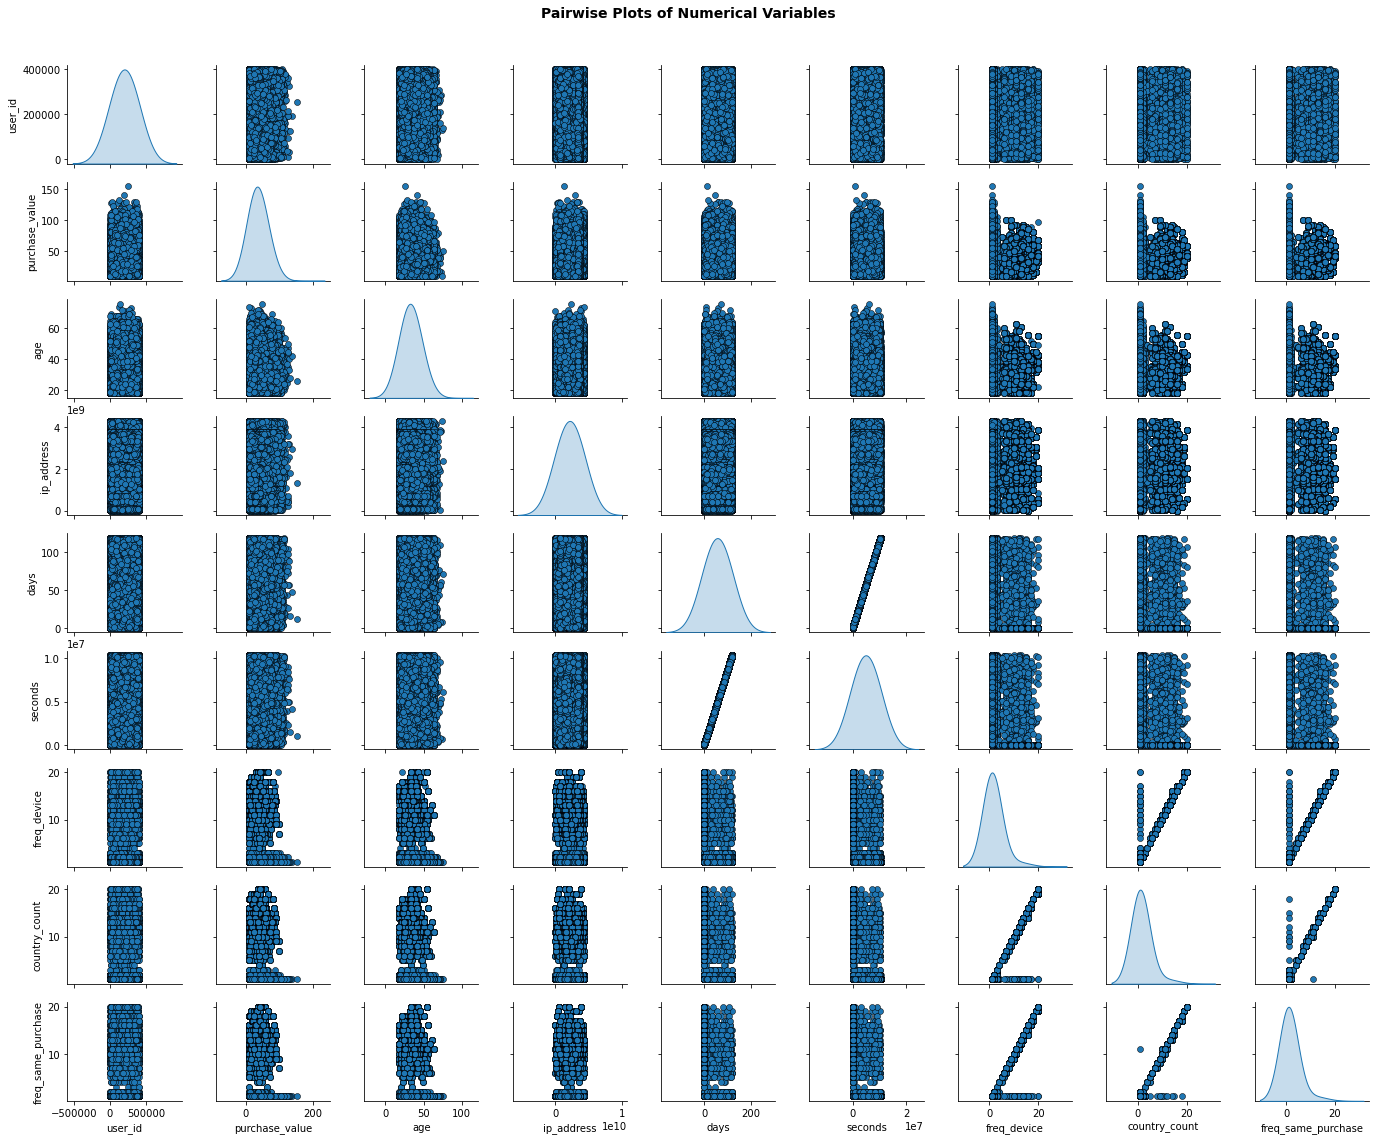

In [20]:
pg = sns.pairplot(data[numerical_variables], 
                  height=1.8, aspect=1.2,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", 
                  diag_kws=dict(shade=True, bw_method=1.5)
                 )
fig = pg.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots of Numerical Variables', fontsize=14, fontweight='bold')

# Feature Selection

Unsupervised feature selection techniques ignores the target variable, such as methods that remove redundant variables using correlation. 

Supervised feature selection techniques use the target variable, such as methods that remove irrelevant variables.

In [124]:
from sklearn.model_selection import train_test_split

y = data[["class"]]
X = data.drop("class", axis = 1)

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

Quantitative Analysis

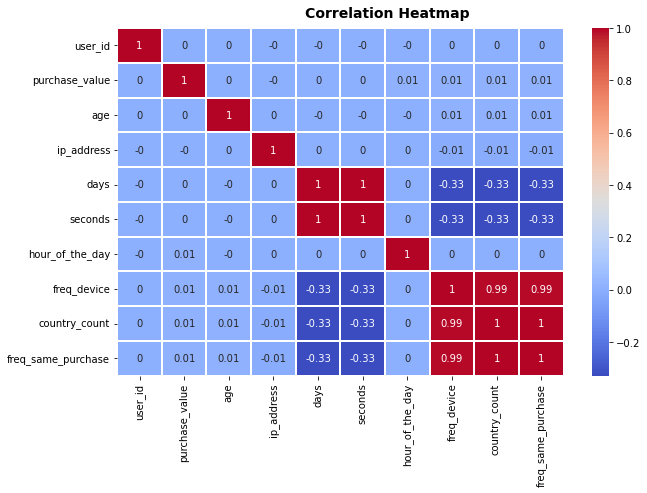

In [129]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(X_train.corr(),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap', fontsize=14, fontweight='bold')

Chi Square Test

The Chi-Square test is a statistical procedure used to examine the differences between categorical variables in the same population. 

In [130]:
cat_variables = ['source', 'browser', 'sex', 'country', 'quick_purchase', 'month_purchase', 'weekday_purchase', 'period_of_the_day', 'risk_country', 'freq_device_cat', 'freq_same_purchase_cat', 'age_category']
p_values = []
chai_stats = []
for cat1 in cat_variables:
    for cat2 in cat_variables:
            crosstab = pd.crosstab(X_train[cat1], X_train[cat2])
            chai2, p_val, _, _ = stats.chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))
     

chisquare = pd.DataFrame(p_values, columns=['cat1', 'cat2', 'p-value'])
chisquare.pivot_table(index='cat1', columns='cat2', values='p-value')

cat2,age_category,browser,country,freq_device_cat,freq_same_purchase_cat,month_purchase,period_of_the_day,quick_purchase,risk_country,sex,source,weekday_purchase
cat1,,,,,,,,,,,,
age_category,0.000000,4.980374e-02,6.837904e-01,1.095980e-02,5.710491e-02,1.264011e-01,4.256345e-01,5.777180e-03,6.933080e-01,8.176748e-01,2.180532e-01,3.670000e-01
browser,0.049804,0.000000e+00,2.969444e-03,6.768365e-17,3.229438e-17,3.423240e-08,2.828609e-02,4.381000e-16,6.034609e-02,5.645050e-01,2.101687e-02,7.917511e-03
country,0.683790,2.969444e-03,0.000000e+00,0.000000e+00,2.360795e-280,2.082224e-38,9.102149e-07,3.727708e-132,0.000000e+00,1.822849e-03,1.978526e-02,2.548939e-04
freq_device_cat,0.010960,6.768365e-17,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.296355e-35,0.000000e+00,1.329303e-148,4.451358e-09,2.782664e-13,7.228007e-48
freq_same_purchase_cat,0.057105,3.229438e-17,2.360795e-280,0.000000e+00,0.000000e+00,0.000000e+00,3.600726e-37,0.000000e+00,6.760662e-147,3.492922e-11,7.044273e-13,2.221030e-48
month_purchase,0.126401,3.423240e-08,2.082224e-38,0.000000e+00,0.000000e+00,0.000000e+00,2.720386e-05,0.000000e+00,2.233982e-77,2.726829e-01,4.108846e-01,5.465603e-255
period_of_the_day,0.425635,2.828609e-02,9.102149e-07,4.296355e-35,3.600726e-37,2.720386e-05,0.000000e+00,3.669383e-18,2.283440e-02,6.598952e-01,8.853060e-02,2.897703e-02
quick_purchase,0.005777,4.381000e-16,3.727708e-132,0.000000e+00,0.000000e+00,0.000000e+00,3.669383e-18,0.000000e+00,9.779108e-128,5.220648e-03,3.394707e-03,5.702885e-53
risk_country,0.693308,6.034609e-02,0.000000e+00,1.329303e-148,6.760662e-147,2.233982e-77,2.283440e-02,9.779108e-128,0.000000e+00,9.433430e-01,2.520027e-01,1.341482e-03


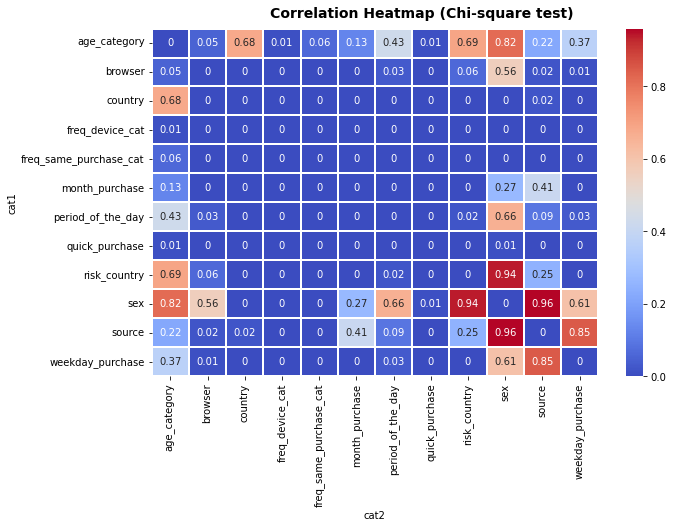

In [131]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(chisquare.pivot_table(index='cat1', columns='cat2', values='p-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap="coolwarm", # Color Map.
                 #square=True,    # If True, set the Axes aspect to “equal” so each cell will be square-shaped.
                 annot=True, 
                 #annot_kws={"size": 14},
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

t = fig.suptitle('Correlation Heatmap (Chi-square test)', fontsize=14, fontweight='bold')

Select top 5 numerical features (SelectKBest for numerical vs numerical data - Pearson’s Correlation Coefficient)

In [103]:
# pearson's correlation feature selection for numeric input and numeric output
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, f_classif
from numpy import array 

# define feature selection
fs = SelectKBest(score_func=f_regression, k=5)
X_train_numeric = X_train[numerical_variables]

# apply feature selection
X_selected = fs.fit_transform(X_train_numeric, y_train)
print(X_selected.shape)

# Get top 9 features
top_features = fs.get_support()
numerical_features = array(X_train_numeric.columns)

numerical_features[top_features]

(120889, 5)


/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['days', 'seconds', 'freq_device', 'country_count',
       'freq_same_purchase'], dtype=object)

Select top 5 numerical features (SelectKBest for numerical vs cat data - ANOVA F measure)

In [104]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=5)
X_train_numeric = X_train[numerical_variables]

# apply feature selection
X_selected = fs.fit_transform(X_train_numeric, y_train)
print(X_selected.shape)

# Get top 9 features
top_features = fs.get_support()
numerical_features = array(X_train_numeric.columns)

numerical_features[top_features]

(120889, 5)


/Users/tohzhiaowei/opt/anaconda3/envs/bt4012/lib/python3.8/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['days', 'seconds', 'freq_device', 'country_count',
       'freq_same_purchase'], dtype=object)

Select top 5 cat features (SelectKBest for cat vs cat data - Chi2)

In [147]:
# define feature selection
fs = SelectKBest(score_func=chi2, k=5)
X_train_cat = X_train[cat_variables]
preprocessing.OneHotEncoder().fit(X_train_cat)
# X_train_cat = X_train_cat.apply(preprocessing.OneHotEncoder().fit_transform)
# X_train_cat

# # apply feature selection
# X_selected = fs.fit_transform(X_train_cat, y_train)
# print(X_selected.shape)

# # Get top 9 features
# top_features = fs.get_support()
# cat_features = array(X_train_cat.columns)

# print(cat_features)
# cat_features[top_features]

TypeError: Encoders require their input to be uniformly strings or numbers. Got ['int', 'str']

Logistic Regression

In [ ]:
# clf_lr = LogisticRegression(max_iter=1000)
# clf_lr.fit(X_train[numerical_variables], data['class'])
# feature_importance = pd.DataFrame({'feature': numerical_variables, 'weight': clf_lr.coef_.squeeze()})
# feature_importance

Count number of transactions with multiple ip address but same device id

In [13]:
groupby_device_ip = data.groupby(['device_id', 'ip_address'])['ip_address'].count().to_frame()

# check user with same device but multiple ip addresses
groupby_device_ip[groupby_device_ip['ip_address']>1]

# check count of ip addresses for unique device id
groupby_device_ip.ip_address.unique()

array([ 1, 11,  8, 14,  7, 12,  9, 13, 10, 15,  6,  4, 17, 19, 16,  5,  3,
       18, 20,  2])

In [50]:
groupby_device_ip = f_data.groupby(['device_id', 'ip_address'])['ip_address'].count().to_frame()

# check user with same device but multiple ip addresses
groupby_device_ip[groupby_device_ip['ip_address']>1]

# check count of ip addresses for unique device id
groupby_device_ip.ip_address.unique()

array([10,  1,  7, 13,  6, 11,  8, 12,  9, 14,  5,  3, 16, 18, 15, 19,  4,
        2, 17])

In [51]:
groupby_device_ip = non_f_data.groupby(['device_id', 'ip_address'])['ip_address'].count().to_frame()

# check user with same device but multiple ip addresses
groupby_device_ip[groupby_device_ip['ip_address']>1]

# check count of ip addresses for unique device id
groupby_device_ip.ip_address.unique()

array([1])

Count the number of transactions from one device with little time difference

In [45]:
data['days'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).dt.days
data['time'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).astype(str).apply(lambda x : x[-8:])
# filter out df with short time difference
short_time_diff = data[(data['days'] == 0) & (data['time'] < '00:00:10')]
# count number of transactions for each device id with short time difference
short_time_diff = short_time_diff.groupby('device_id')['purchase_value'].count()
short_time_diff

device_id
AAAXXOZJRZRAO    10
AANYBGQSWHRTK     7
ADEDUDCYQMYTI    13
AENUQLGTUHYMS     6
AIGPGDVRDKOKT    11
                 ..
ZYHVSPGHWACPO     5
ZYZQZXBXADPST    15
ZZCAWCKYVMWNH     8
ZZFFPOVMCQVCG     6
ZZQPVRBHRMVYD    11
Name: purchase_value, Length: 760, dtype: int64

In [56]:
data = non_f_data.copy()
data['days'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).dt.days
data['time'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).astype(str).apply(lambda x : x[-8:])
# filter out df with short time difference
short_time_diff = data[(data['days'] == 0) & (data['time'] < '00:00:10')]
# count number of transactions for each device id with short time difference
short_time_diff = short_time_diff.groupby('device_id')['purchase_value'].count().reset_index().rename(columns={'purchase_value': 'purchase_count'})
short_time_diff.purchase_count.unique()

array([], dtype=int64)

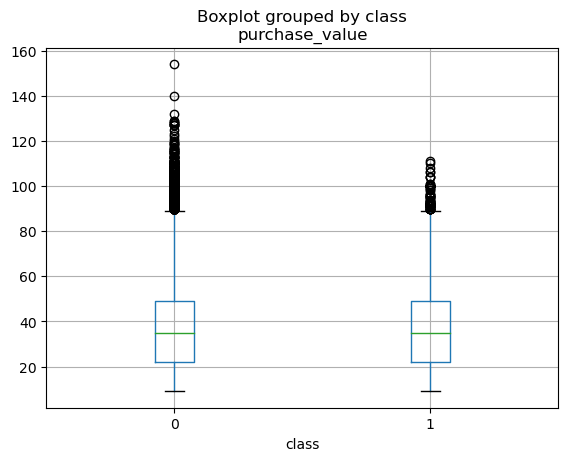

In [82]:
df = data[['purchase_value', 'class']]
df.boxplot(column='purchase_value', by='class').figure
# data['class'].unique()

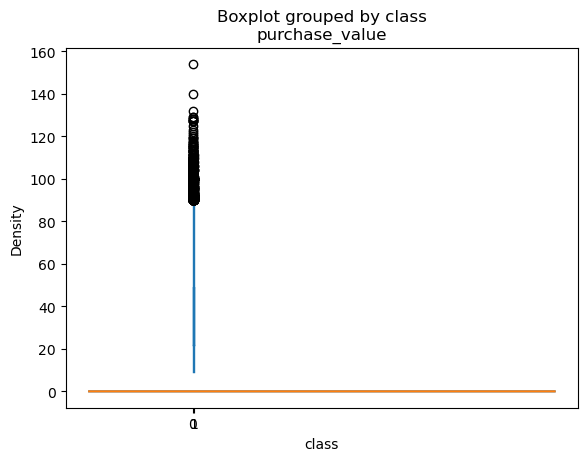

In [85]:
data['purchase_value'].plot.kde().figure

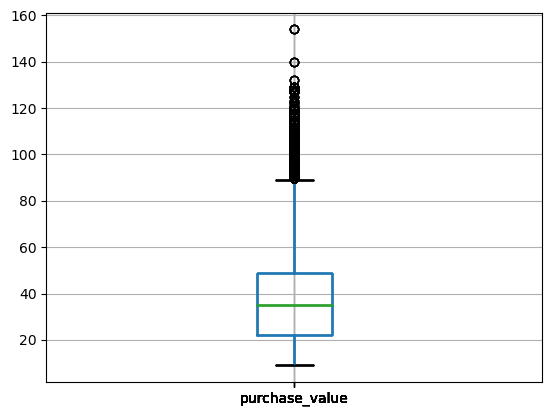

In [66]:
f_data.boxplot(column='purchase_value').figure

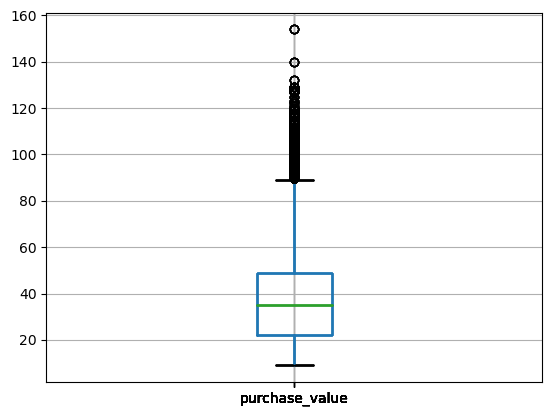

In [67]:
non_f_data.boxplot(column='purchase_value').figure

In [15]:
df = df.rename(columns={'ip_address': 'lower_bound_ip_address'})
df
new = df.set_index('lower_bound_ip_address').join(ip_country, on='lower_bound_ip_address', how='left')
new

/Users/tohzhiaowei/opt/anaconda3/envs/bt4012_deep_learning/lib/python3.7/site-packages/pandas/core/reshape/merge.py:1208: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,class,lower_bound_ip_address,upper_bound_ip_address,country
lower_bound_ip_address,,,,,,,,,,,,,
7.327584e+08,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,0,NaN,NaN,NaN
3.503114e+08,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,0,NaN,NaN,NaN
2.621474e+09,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,1,NaN,NaN,NaN
3.840542e+09,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,0,NaN,NaN,NaN
4.155831e+08,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.451155e+09,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,1,NaN,NaN,NaN
2.439047e+09,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,0,NaN,NaN,NaN
2.748471e+09,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,0,NaN,NaN,NaN


In [3]:
df.source.unique()

array(['SEO', 'Ads', 'Direct'], dtype=object)

In [4]:
df.browser.unique()

array(['Chrome', 'Opera', 'Safari', 'IE', 'FireFox'], dtype=object)